<a href="https://colab.research.google.com/github/rimishadsilva/Image-Inpainting/blob/main/imginpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image as mg
import cv2
import numpy as np
import tensorflow as tf

In [ ]:

WILD_PATH = 'wild'
IMAGE_SIZE = 128

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = os.listdir('/content/drive/MyDrive/Final')
train_dir='/content/drive/MyDrive/Final'

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
trains = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="training",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
vals = tf.keras.utils.image_dataset_from_directory(train_dir,validation_split=0.3,subset="validation",seed=123,image_size=(IMAGE_SIZE, IMAGE_SIZE),)
trains = trains.unbatch()
vals = vals.unbatch()
train = []
test = []
for x,y in trains:
    train.append(x.astype('float32')/255.)
for x,y in vals:
    test.append(x.astype('float32')/255.)
train = tf.convert_to_tensor(train)
test = tf.convert_to_tensor(test)

Found 5891 files belonging to 1 classes.
Using 4124 files for training.
Found 5891 files belonging to 1 classes.
Using 1767 files for validation.


In [ ]:
print(train.shape)
print(test.shape)

(4124, 128, 128, 3)
(1767, 128, 128, 3)


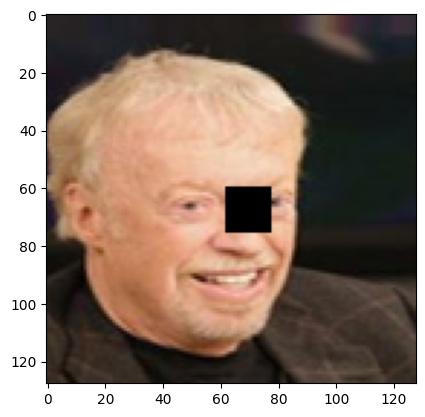

In [ ]:
#generating masks
left = 60
right = 76
up = 78
down = 62
x_train = train.numpy()
black_train = x_train.copy()
black_train[:,left:right,down:up,:] = 0
train_labels = x_train[:,left:right,down:up,:]
x_test = test.numpy()
black_test = x_test.copy()
black_test[:,left:right,down:up,:] = 0
test_labels = x_test[:,left:right,down:up,:]
plt.imshow(black_test[0])


In [ ]:
from tensorflow.keras.models import Model

encoder_in = tf.keras.Input(shape=(128,128,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),pad  ding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)
decoder_in = tf.keras.layers.Dense(1024,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,16))(decoder_in)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(128,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)
decoder_out = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)


autoencoder = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
# autoencoder.summary()


In [ ]:

optimizer = tf.keras.optimizers.Adam(lr = 0.001)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(black_train,train_labels ,
                epochs=50,
                shuffle=True,
                batch_size=10,
                validation_data=(black_test,test_labels))

Epoch 1/50
413/413 [==============================] - 24s 22ms/step - loss: 0.0488 - accuracy: 0.8362 - val_loss: 0.0150 - val_accuracy: 0.9839
Epoch 2/50
413/413 [==============================] - 7s 18ms/step - loss: 0.0135 - accuracy: 0.9833 - val_loss: 0.0119 - val_accuracy: 0.9849
Epoch 3/50
413/413 [==============================] - 7s 18ms/step - loss: 0.0108 - accuracy: 0.9836 - val_loss: 0.0103 - val_accuracy: 0.9849
Epoch 4/50
413/413 [==============================] - 7s 18ms/step - loss: 0.0094 - accuracy: 0.9836 - val_loss: 0.0101 - val_accuracy: 0.9849
Epoch 5/50
413/413 [==============================] - 8s 20ms/step - loss: 0.0084 - accuracy: 0.9836 - val_loss: 0.0094 - val_accuracy: 0.9849
Epoch 6/50
413/413 [==============================] - 7s 17ms/step - loss: 0.0076 - accuracy: 0.9836 - val_loss: 0.0090 - val_accuracy: 0.9849
Epoch 7/50
413/413 [==============================] - 8s 18ms/step - loss: 0.0068 - accuracy: 0.9836 - val_loss: 0.0097 - val_accuracy: 0.984

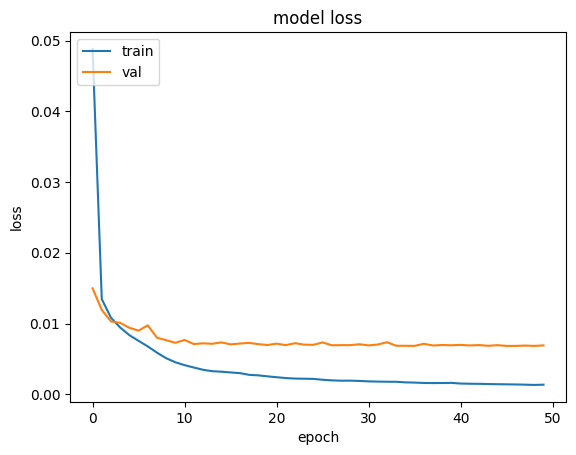

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

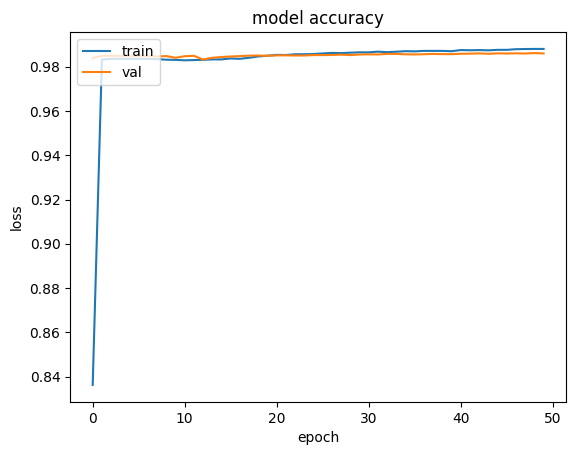

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 319ms/step


Text(0.5, 1.0, 'Masked Image')

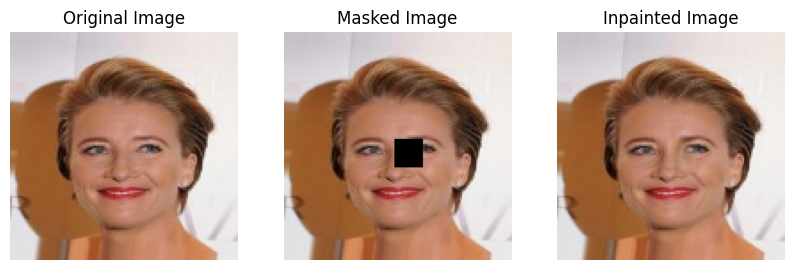

In [ ]:
import random
index = random.randint(0,test.shape[0])
ry = autoencoder.predict(black_test[index].reshape(-1,128,128,3))
pic = black_test[index].copy()
pic[left:right,down:up] = ry
rows = 1
colls = 3
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows,colls,3)
plt.imshow(pic)
plt.axis('off')
plt.title("Inpainted Image")
fig.add_subplot(rows,colls,1)
plt.imshow(test[index])
plt.axis('off')
plt.title("Original Image")
fig.add_subplot(rows,colls,2)
plt.imshow(black_test[index])
plt.axis('off')
plt.title("Masked Image")

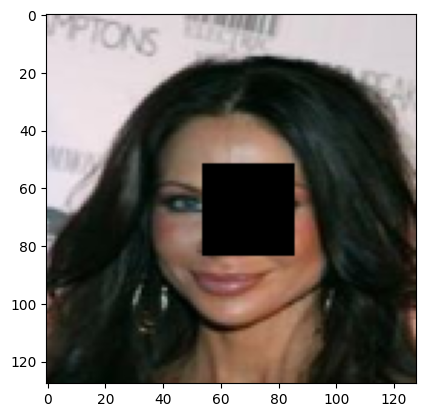

In [ ]:
#generating 32x32 holes
left = 52
right = 84
up = 86
down = 54
black_train_bigger = x_train.copy()
black_train_bigger[:,left:right,down:up,:] = 0
train_labels_bigger = x_train[:,left:right,down:up,:]
black_test_bigger = x_test.copy()
black_test_bigger[:,left:right,down:up,:] = 0
test_labels_bigger = x_test[:,left:right,down:up,:]
plt.imshow(black_train_bigger[0])

In [ ]:
from tensorflow.keras.models import Model

encoder_in = tf.keras.Input(shape=(128,128,3),name='img_input')
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(encoder_in)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.MaxPooling2D((2,2),padding='same')(layer)
layer = tf.keras.layers.Flatten()(layer)
encoder_out = tf.keras.layers.Dense(1024,activation='relu')(layer)

decoder_in = tf.keras.layers.Dense(1024,activation='relu')(encoder_out)
layer = tf.keras.layers.Reshape((8,8,16))(decoder_in)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(layer)
layer = layer = tf.keras.layers.Conv2DTranspose(64,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(128,(3,3),activation='relu',padding='same')(layer)
layer = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)
decoder_out = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same',strides=(2,2))(layer)


autoencoder = tf.keras.Model(encoder_in,decoder_out,name='an_dec')
# autoencoder.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(),metrics='accuracy')
history = autoencoder.fit(black_train_bigger,train_labels_bigger ,
                epochs=50,
                shuffle=True,
                batch_size=10,
                validation_data=(black_test_bigger,test_labels_bigger))


Epoch 1/50
413/413 [==============================] - 12s 22ms/step - loss: 0.0901 - accuracy: 0.6679 - val_loss: 0.0368 - val_accuracy: 0.9671
Epoch 2/50
413/413 [==============================] - 7s 18ms/step - loss: 0.0344 - accuracy: 0.9772 - val_loss: 0.0343 - val_accuracy: 0.9825
Epoch 3/50
413/413 [==============================] - 8s 20ms/step - loss: 0.0283 - accuracy: 0.9822 - val_loss: 0.0183 - val_accuracy: 0.9824
Epoch 4/50
413/413 [==============================] - 8s 19ms/step - loss: 0.0139 - accuracy: 0.9822 - val_loss: 0.0144 - val_accuracy: 0.9824
Epoch 5/50
413/413 [==============================] - 8s 19ms/step - loss: 0.0124 - accuracy: 0.9817 - val_loss: 0.0127 - val_accuracy: 0.9825
Epoch 6/50
413/413 [==============================] - 7s 18ms/step - loss: 0.0107 - accuracy: 0.9822 - val_loss: 0.0129 - val_accuracy: 0.9825
Epoch 7/50
413/413 [==============================] - 8s 19ms/step - loss: 0.0100 - accuracy: 0.9822 - val_loss: 0.0120 - val_accuracy: 0.982

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Masked Image')

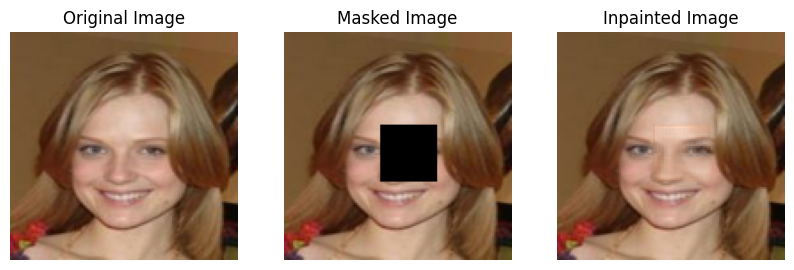

In [ ]:
import random
index = random.randint(0,test.shape[0])
ry = autoencoder.predict(black_test_bigger[index].reshape(-1,128,128,3))
pic = black_test[index].copy()
pic[left:right,down:up] = ry
rows = 1
colls = 3
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows,colls,3)
plt.imshow(pic)
plt.axis('off')
plt.title("Inpainted Image")
fig.add_subplot(rows,colls,1)
plt.imshow(test[index])
plt.axis('off')
plt.title("Original Image")
fig.add_subplot(rows,colls,2)
plt.imshow(black_test_bigger[index])
plt.axis('off')
plt.title("Masked Image")

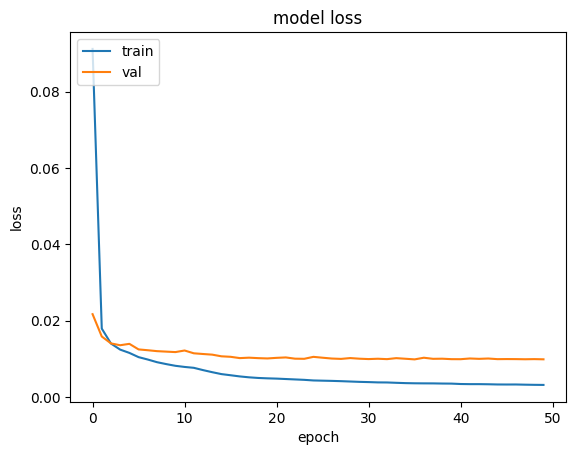

[0.09116913378238678, 0.017906559631228447, 0.013985837809741497, 0.012395297177135944, 0.01153330784291029, 0.010423991829156876, 0.00979630183428526, 0.009101787582039833, 0.008602057583630085, 0.008154411800205708, 0.007856572978198528, 0.007626773323863745, 0.007028279360383749, 0.006482402328401804, 0.005981497932225466, 0.005679241381585598, 0.00537135498598218, 0.005135550629347563, 0.0049700308591127396, 0.004869423341006041, 0.004797421861439943, 0.004688852932304144, 0.004582462832331657, 0.004475767258554697, 0.004315628670156002, 0.0042573995888233185, 0.004203283227980137, 0.0041293674148619175, 0.004037915263324976, 0.003946887329220772, 0.00388609291985631, 0.0038071901071816683, 0.0037883659824728966, 0.0036984288599342108, 0.003618131158873439, 0.003572875866666436, 0.0035535802599042654, 0.0035455760080367327, 0.0035066711716353893, 0.0034885723143815994, 0.0033831591717898846, 0.0033510003704577684, 0.0033503815066069365, 0.003318424802273512, 0.0032648066990077496, 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(history.history['loss'])

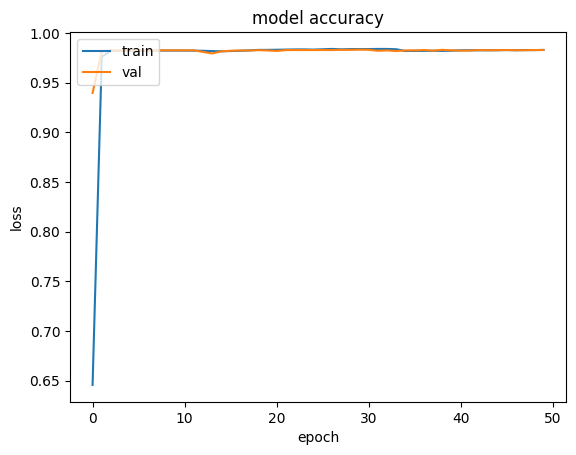

[0.645721435546875, 0.9760507941246033, 0.981895923614502, 0.9821026921272278, 0.982168972492218, 0.9822094440460205, 0.9822236895561218, 0.9822279214859009, 0.9822272062301636, 0.9822274446487427, 0.9822239279747009, 0.9821995496749878, 0.9820001125335693, 0.9817164540290833, 0.9814926981925964, 0.9817581176757812, 0.9820041656494141, 0.9824199676513672, 0.9829220175743103, 0.9829352498054504, 0.9830479621887207, 0.9832367300987244, 0.9833816289901733, 0.9834112524986267, 0.98321133852005, 0.983536958694458, 0.9838990569114685, 0.9834787249565125, 0.9837292432785034, 0.9837993383407593, 0.9837619066238403, 0.9838881492614746, 0.9838876724243164, 0.9835720062255859, 0.9818066954612732, 0.9818904995918274, 0.9819186925888062, 0.9820318818092346, 0.9819172620773315, 0.9820995926856995, 0.9825106859207153, 0.9825255870819092, 0.9825253486633301, 0.9824879169464111, 0.9825940132141113, 0.982758104801178, 0.9825241565704346, 0.9827747344970703, 0.9827193021774292, 0.9829196333885193]


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(history.history['accuracy'])